https://www.kaggle.com/datasets/prasy46/credit-score-prediction

https://www.kaggle.com/datasets/parisrohan/credit-score-classification?select=train.csv

https://github.com/max-fitzpatrick/Credit-scoring-model/blob/master/CREDIT_SCORING_NOTEBOOK.ipynb

In [ ]:
!kaggle datasets download -d parisrohan/credit-score-classification

# Imports

In [1]:
import pandas as pd
import numpy as np

import os
import sys

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer,SimpleImputer

from datasist.structdata import detect_outliers

import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.metrics import Precision, Recall, Accuracy
from tensorflow.keras.optimizers import SGD

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [166]:
train_df = pd.read_csv('./credit-score-classification/train.csv',low_memory=False)
test_df = pd.read_csv('./credit-score-classification/test.csv',low_memory=False)

# Data Visualization

In [4]:
train_df.head()

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,_,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.944960,NaN,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.4580743910713,Low_spent_Small_value_payments,223.45130972736786,Good
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153086217326,High_spent_Medium_value_payments,341.48923103222177,Good


In [6]:
len(train_df), len(test_df)

(100000, 50000)

In [12]:
train_df.shape, test_df.shape

((100000, 28), (50000, 27))

In [13]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        100000 non-null  object 
 1   Customer_ID               100000 non-null  object 
 2   Month                     100000 non-null  object 
 3   Name                      90015 non-null   object 
 4   Age                       100000 non-null  object 
 5   SSN                       100000 non-null  object 
 6   Occupation                100000 non-null  object 
 7   Annual_Income             100000 non-null  object 
 8   Monthly_Inhand_Salary     84998 non-null   float64
 9   Num_Bank_Accounts         100000 non-null  int64  
 10  Num_Credit_Card           100000 non-null  int64  
 11  Interest_Rate             100000 non-null  int64  
 12  Num_of_Loan               100000 non-null  object 
 13  Type_of_Loan              88592 non-null   ob

In [14]:
train_df.isna().sum()

ID                              0
Customer_ID                     0
Month                           0
Name                         9985
Age                             0
SSN                             0
Occupation                      0
Annual_Income                   0
Monthly_Inhand_Salary       15002
Num_Bank_Accounts               0
Num_Credit_Card                 0
Interest_Rate                   0
Num_of_Loan                     0
Type_of_Loan                11408
Delay_from_due_date             0
Num_of_Delayed_Payment       7002
Changed_Credit_Limit            0
Num_Credit_Inquiries         1965
Credit_Mix                      0
Outstanding_Debt                0
Credit_Utilization_Ratio        0
Credit_History_Age           9030
Payment_of_Min_Amount           0
Total_EMI_per_month             0
Amount_invested_monthly      4479
Payment_Behaviour               0
Monthly_Balance              1200
Credit_Score                    0
dtype: int64

In [16]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Monthly_Inhand_Salary,84998.0,4194.170850,3183.686167,303.645417,1625.568229,3093.745000,5957.448333,15204.633333
Num_Bank_Accounts,100000.0,17.091280,117.404834,-1.000000,3.000000,6.000000,7.000000,1798.000000
Num_Credit_Card,100000.0,22.474430,129.057410,0.000000,4.000000,5.000000,7.000000,1499.000000
Interest_Rate,100000.0,72.466040,466.422621,1.000000,8.000000,13.000000,20.000000,5797.000000
Delay_from_due_date,100000.0,21.068780,14.860104,-5.000000,10.000000,18.000000,28.000000,67.000000
Num_Credit_Inquiries,98035.0,27.754251,193.177339,0.000000,3.000000,6.000000,9.000000,2597.000000
Credit_Utilization_Ratio,100000.0,32.285173,5.116875,20.000000,28.052567,32.305784,36.496663,50.000000
Total_EMI_per_month,100000.0,1403.118217,8306.041270,0.000000,30.306660,69.249473,161.224249,82331.000000


In [18]:
train_df.duplicated().sum()

0

In [46]:
def plot_col_counts(df,column,figsize=(10,5)):
    plt.figure(figsize=figsize)
    sns.countplot(x=df[column],palette="mako",hue=df[column])
    plt.xlabel(column, size=12)
    plt.xticks(rotation=45)
    plt.show()

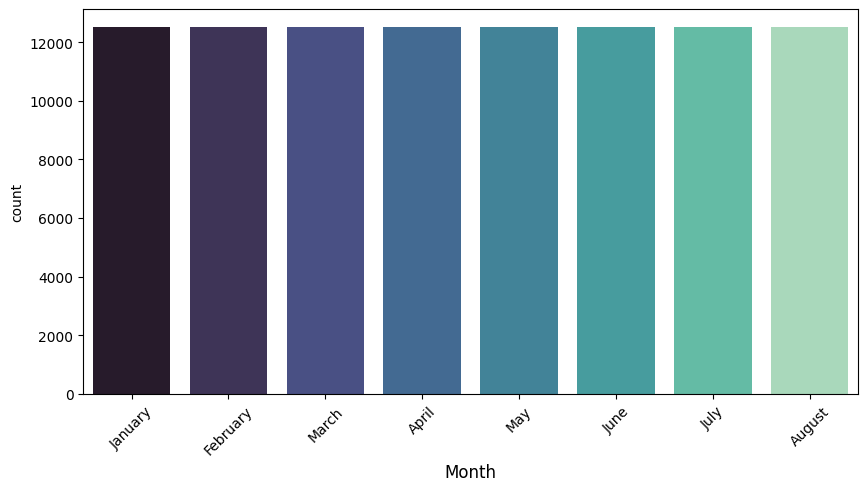

In [49]:
plot_col_counts(train_df, 'Month')

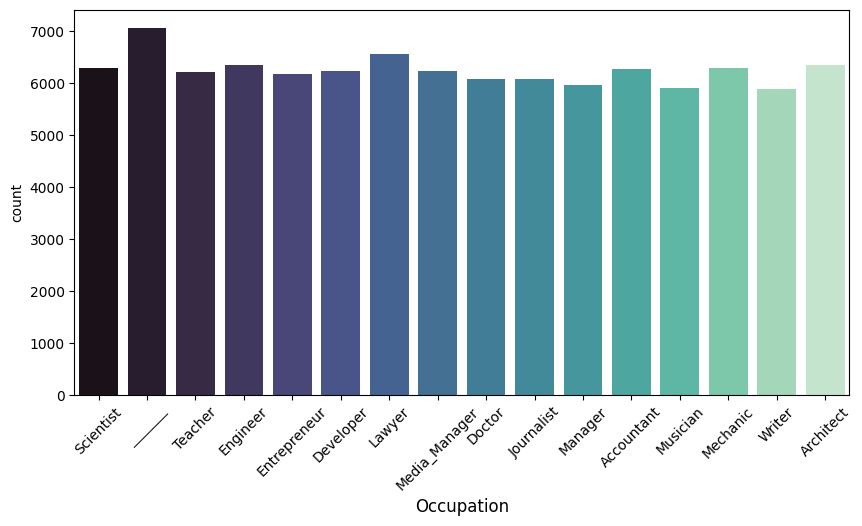

In [50]:
plot_col_counts(train_df, 'Occupation')

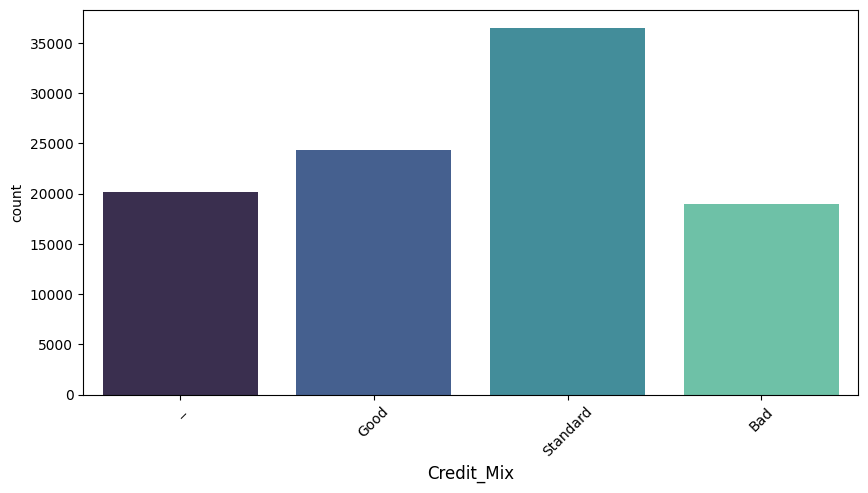

In [51]:
plot_col_counts(train_df, 'Credit_Mix')

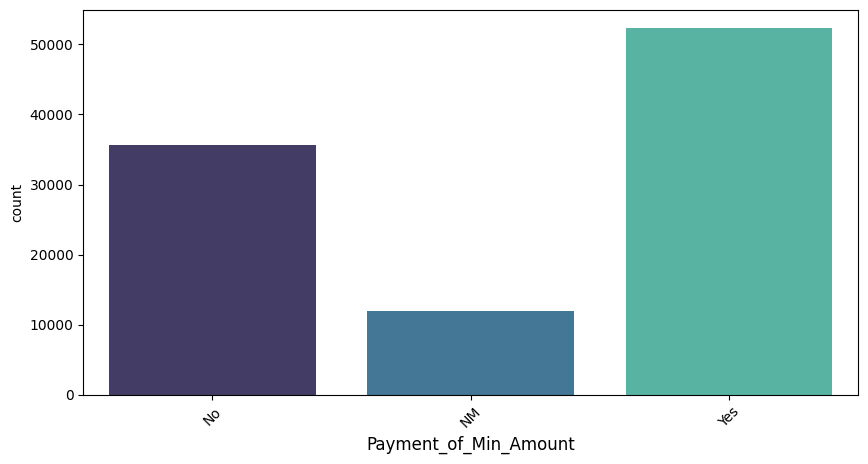

In [52]:
plot_col_counts(train_df, 'Payment_of_Min_Amount')

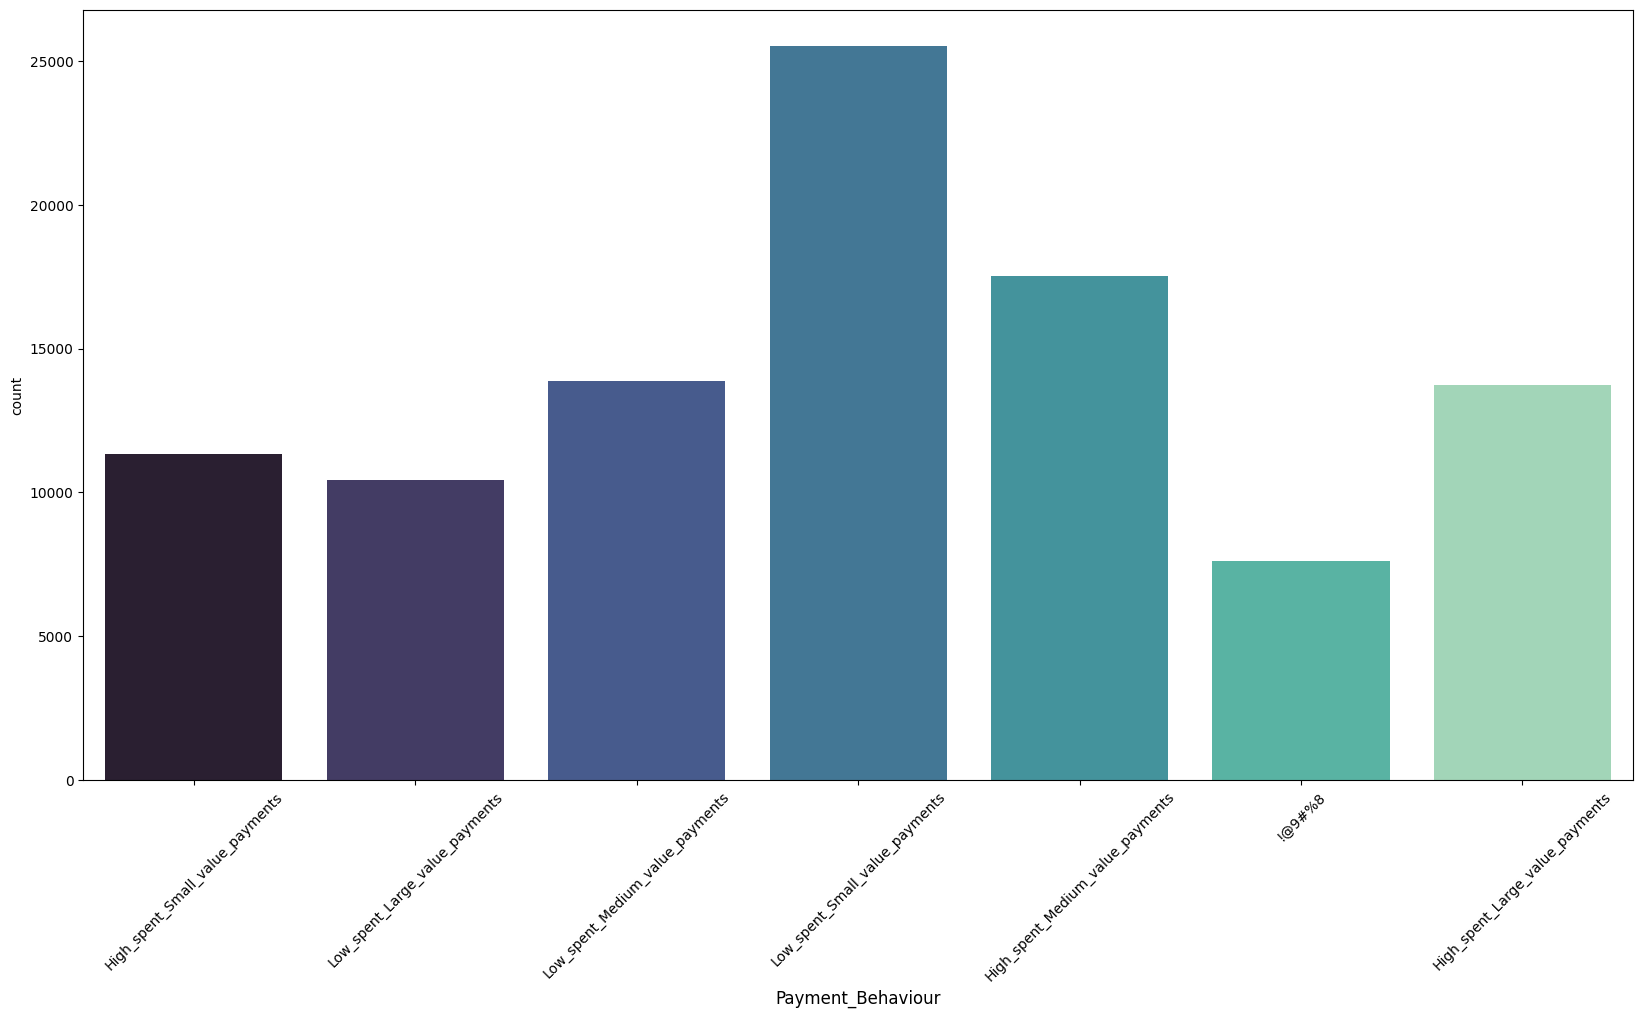

In [53]:
plot_col_counts(train_df, 'Payment_Behaviour',figsize=(20,10))

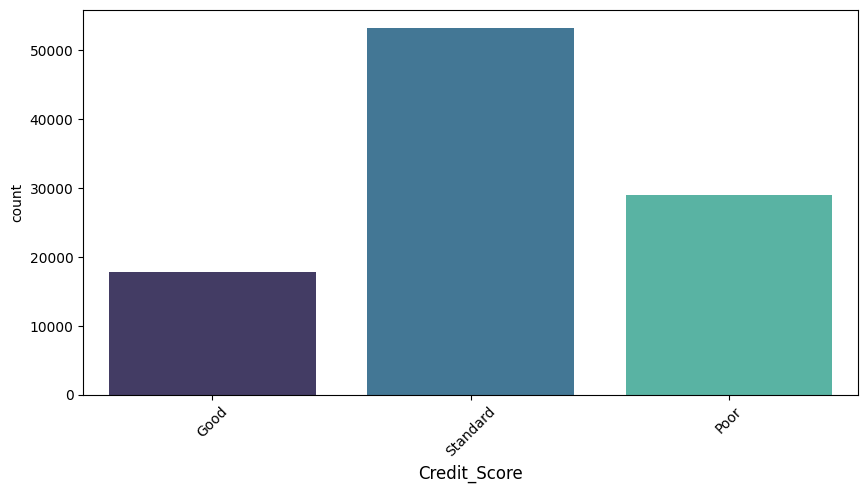

In [56]:
plot_col_counts(train_df, 'Credit_Score')

In [55]:
train_df['Credit_Score'].value_counts(normalize=True)

Credit_Score
Standard    0.53174
Poor        0.28998
Good        0.17828
Name: proportion, dtype: float64

In [69]:
def plot_distplot(column,df=train_df):
    sns.displot(df[column],kde=True)

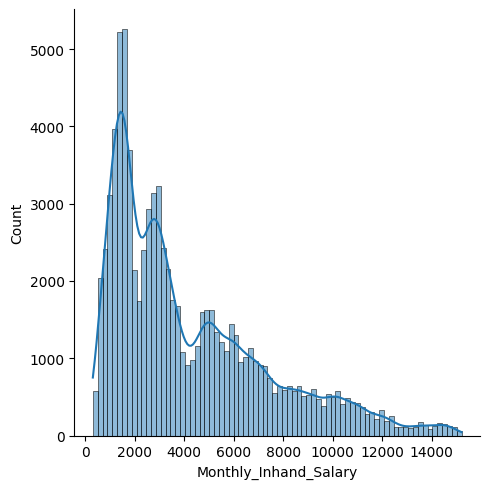

In [70]:
plot_distplot('Monthly_Inhand_Salary')

In [63]:
train_df['Num_Bank_Accounts'].value_counts()

Num_Bank_Accounts
6       13001
7       12823
8       12765
4       12186
5       12118
        ...  
1626        1
1470        1
887         1
211         1
697         1
Name: count, Length: 943, dtype: int64

C:\Users\001\AppData\Local\Temp\ipykernel_18140\3307175724.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x=train_df['Num_Bank_Accounts'])


<Axes: ylabel='Density'>

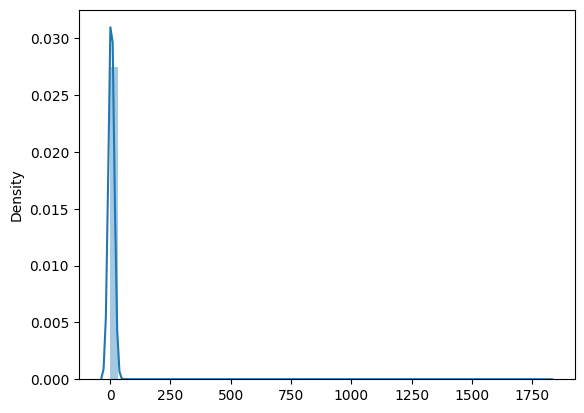

In [71]:
sns.distplot(x=train_df['Num_Bank_Accounts'])

C:\Users\001\AppData\Local\Temp\ipykernel_18140\3018106928.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_df['Num_Credit_Card'])


<Axes: xlabel='Num_Credit_Card', ylabel='Density'>

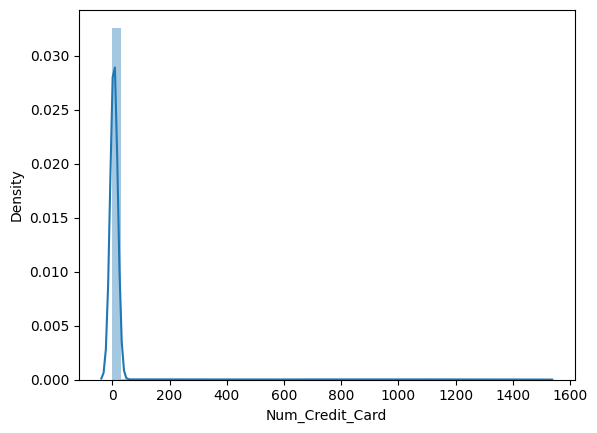

In [79]:
sns.distplot(train_df['Num_Credit_Card'])

C:\Users\001\AppData\Local\Temp\ipykernel_18140\4294712038.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_df['Interest_Rate'])


<Axes: xlabel='Interest_Rate', ylabel='Density'>

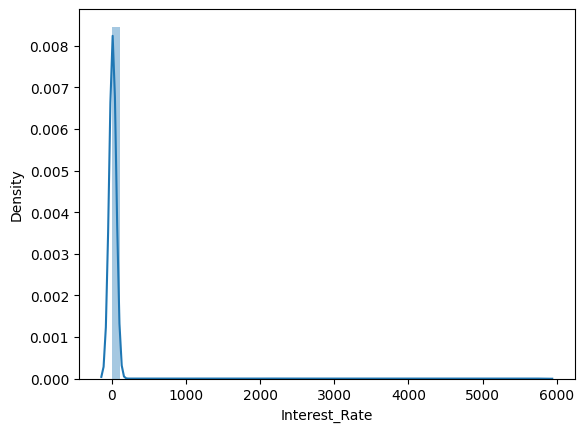

In [80]:
sns.distplot(train_df['Interest_Rate'])

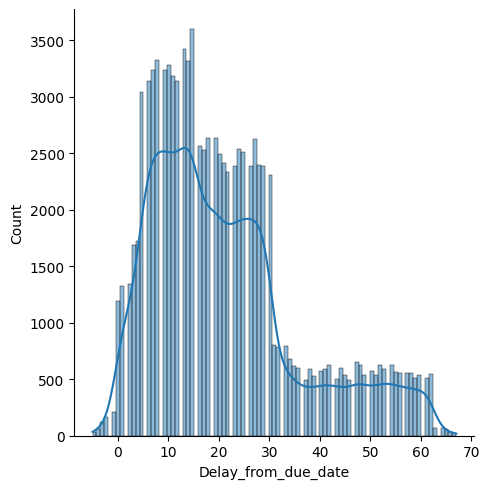

In [85]:
plot_distplot('Delay_from_due_date')

C:\Users\001\AppData\Local\Temp\ipykernel_18140\2866512621.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_df['Num_Credit_Inquiries'])


<Axes: xlabel='Num_Credit_Inquiries', ylabel='Density'>

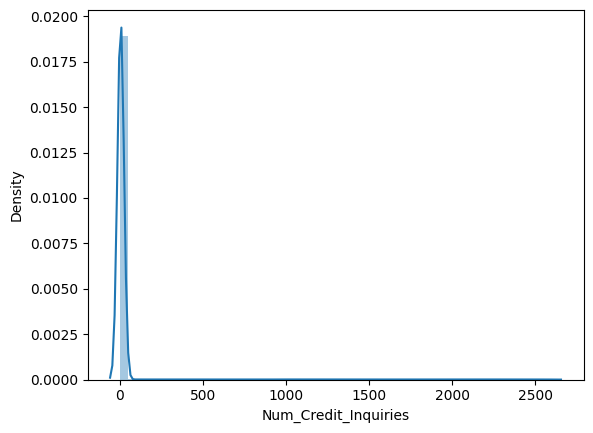

In [87]:
sns.distplot(train_df['Num_Credit_Inquiries'])

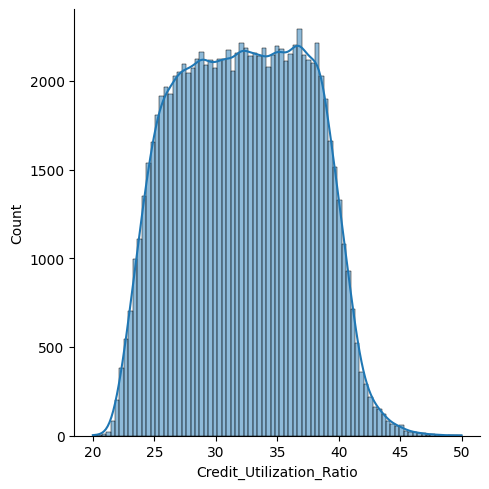

In [88]:
plot_distplot('Credit_Utilization_Ratio')

C:\Users\001\AppData\Local\Temp\ipykernel_18140\3261247161.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_df['Total_EMI_per_month']);


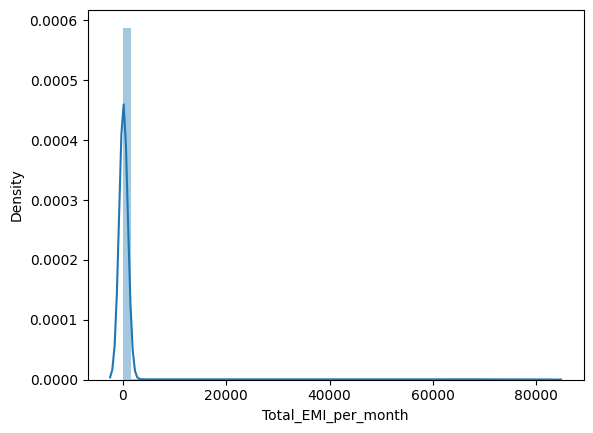

In [89]:
sns.distplot(train_df['Total_EMI_per_month']);

In [91]:
train_df['Type_of_Loan'].value_counts().head(10)

Type_of_Loan
Not Specified                      1408
Credit-Builder Loan                1280
Personal Loan                      1272
Debt Consolidation Loan            1264
Student Loan                       1240
Payday Loan                        1200
Mortgage Loan                      1176
Auto Loan                          1152
Home Equity Loan                   1136
Personal Loan, and Student Loan     320
Name: count, dtype: int64

# Data Cleaning

The following 3 attributes contribute nothing to the data:
1. ID
2. Name
3. SSN

In [167]:
del train_df['ID'] # Identification 
del train_df['Name'] # Name of client 
del train_df['SSN'] # SSN (social security number of a person)

In [93]:
train_df.head()

,Customer_ID,Month,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,CUS_0xd40,January,23,Scientist,19114.12,1824.843333,3,4,3,4,...,_,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good
1,CUS_0xd40,February,23,Scientist,19114.12,NaN,3,4,3,4,...,Good,809.98,31.944960,NaN,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good
2,CUS_0xd40,March,-500,Scientist,19114.12,NaN,3,4,3,4,...,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good
3,CUS_0xd40,April,23,Scientist,19114.12,NaN,3,4,3,4,...,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.4580743910713,Low_spent_Small_value_payments,223.45130972736786,Good
4,CUS_0xd40,May,23,Scientist,19114.12,1824.843333,3,4,3,4,...,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153086217326,High_spent_Medium_value_payments,341.48923103222177,Good


In [98]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 25 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Customer_ID               100000 non-null  object 
 1   Month                     100000 non-null  object 
 2   Age                       100000 non-null  object 
 3   Occupation                100000 non-null  object 
 4   Annual_Income             100000 non-null  object 
 5   Monthly_Inhand_Salary     84998 non-null   float64
 6   Num_Bank_Accounts         100000 non-null  int64  
 7   Num_Credit_Card           100000 non-null  int64  
 8   Interest_Rate             100000 non-null  int64  
 9   Num_of_Loan               100000 non-null  object 
 10  Type_of_Loan              88592 non-null   object 
 11  Delay_from_due_date       100000 non-null  int64  
 12  Num_of_Delayed_Payment    92998 non-null   object 
 13  Changed_Credit_Limit      100000 non-null  ob

In [106]:
train_df['Age'].unique()

array(['23', '-500', '28_', ..., '4808_', '2263', '1342'], dtype=object)

In [104]:
folder_name = "./value_counts"
os.makedirs(folder_name, exist_ok=True)
"Folder created successfully" if os.path.exists(folder_name) else "Folder creation failed"

'Folder created successfully'

In [107]:
train_df.iloc[:,:-1].columns

Index(['Customer_ID', 'Month', 'Age', 'Occupation', 'Annual_Income',
       'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card',
       'Interest_Rate', 'Num_of_Loan', 'Type_of_Loan', 'Delay_from_due_date',
       'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'Credit_Mix', 'Outstanding_Debt',
       'Credit_Utilization_Ratio', 'Credit_History_Age',
       'Payment_of_Min_Amount', 'Total_EMI_per_month',
       'Amount_invested_monthly', 'Payment_Behaviour', 'Monthly_Balance'],
      dtype='object')

In [109]:
for col in train_df.iloc[:,:-1].columns:
    train_df[col].value_counts().to_csv(folder_name+'/'+col)

The below columns have dtypes 'object', however they are supposed to be numbers, also some of these columns have '_' in their values

In [122]:
train_df.select_dtypes(include=['object']).columns

Index(['Customer_ID', 'Month', 'Age', 'Occupation', 'Annual_Income',
       'Num_of_Loan', 'Type_of_Loan', 'Num_of_Delayed_Payment',
       'Changed_Credit_Limit', 'Credit_Mix', 'Outstanding_Debt',
       'Credit_History_Age', 'Payment_of_Min_Amount',
       'Amount_invested_monthly', 'Payment_Behaviour', 'Monthly_Balance',
       'Credit_Score'],
      dtype='object')

In [168]:
cols_with_underscore = []
obj_columns = train_df.iloc[:,:-1].select_dtypes(include=['object']).columns
for col in obj_columns:
    unique = train_df[col].unique()
    # print(col)
    for val in unique:
        # print(val)
        if val is not np.nan and '_' in val:
            cols_with_underscore.append(col)
            break
cols_with_underscore   

['Customer_ID',
 'Age',
 'Occupation',
 'Annual_Income',
 'Num_of_Loan',
 'Num_of_Delayed_Payment',
 'Changed_Credit_Limit',
 'Credit_Mix',
 'Outstanding_Debt',
 'Amount_invested_monthly',
 'Payment_Behaviour',
 'Monthly_Balance']

In [169]:
num_cols_to_fix = ['Age', 'Annual_Income', 'Num_of_Loan', 'Num_of_Delayed_Payment', 
            'Changed_Credit_Limit', 'Amount_invested_monthly', 'Outstanding_Debt' , 'Monthly_Balance']

In [170]:
def fix_nums(num):
    try : 
        return float(num.replace("_",""))
    except :
        return np.nan

In [171]:
for col in num_cols_to_fix :
    train_df[col] = train_df[col].apply(fix_nums)

In [172]:
train_df.dtypes

Customer_ID                  object
Month                        object
Age                         float64
Occupation                   object
Annual_Income               float64
Monthly_Inhand_Salary       float64
Num_Bank_Accounts             int64
Num_Credit_Card               int64
Interest_Rate                 int64
Num_of_Loan                 float64
Type_of_Loan                 object
Delay_from_due_date           int64
Num_of_Delayed_Payment      float64
Changed_Credit_Limit        float64
Num_Credit_Inquiries        float64
Credit_Mix                   object
Outstanding_Debt            float64
Credit_Utilization_Ratio    float64
Credit_History_Age           object
Payment_of_Min_Amount        object
Total_EMI_per_month         float64
Amount_invested_monthly     float64
Payment_Behaviour            object
Monthly_Balance             float64
Credit_Score                 object
dtype: object

In [173]:
new_cols_with_underscore = []
for col in cols_with_underscore:
    if train_df.dtypes[col]==np.float64:
        continue
    unique = train_df[col].unique()
    # print(col)
    for val in unique:
        # print(val)
        if val is not np.nan and '_' in val:
            new_cols_with_underscore.append(col)
            break
new_cols_with_underscore 

['Customer_ID', 'Occupation', 'Credit_Mix', 'Payment_Behaviour']

In [174]:
train_df['Type_of_Loan'].value_counts().head(10)

Type_of_Loan
Not Specified                      1408
Credit-Builder Loan                1280
Personal Loan                      1272
Debt Consolidation Loan            1264
Student Loan                       1240
Payday Loan                        1200
Mortgage Loan                      1176
Auto Loan                          1152
Home Equity Loan                   1136
Personal Loan, and Student Loan     320
Name: count, dtype: int64

In [175]:
for i in train_df['Type_of_Loan'].value_counts().head(9).index[1:]: 
    train_df[i] = train_df['Type_of_Loan'].str.contains(i)

In [176]:
del train_df['Type_of_Loan']

In [177]:
train_df['Num_Bank_Accounts'] = train_df['Num_Bank_Accounts'].apply(lambda x :abs (x))

In [178]:
train_df['Num_Credit_Card'].replace(0,1,inplace=True)

In [220]:
def get_num(st):
    st = st.strip()
    num_str = ''
    for char in st:
        if char==' ':
            break
        num_str+=char if 0<=int(char)<=9 else ''
    return int(num_str)

def history_age(age):
    try : 
        years, months = age.split('and')
        years = get_num(years)
        print(years)
        months = get_num(months)
        # print(months)
        return years*12 + months
    except :
        return np.nan

In [221]:
history_age('   0     Years     and    13    Months    ')

0


13

In [ ]:
train_df['Credit_History_Age'] = train_df['Credit_History_Age'].apply(history_age)

In [225]:
train_df['Credit_History_Age'].unique()

array([265.,  nan, 267., 268., 269., 270., 271., 319., 320., 321., 322.,
       323., 324., 325., 326., 213., 214., 215., 217., 218., 219., 220.,
       207., 208., 209., 210., 211., 212., 368., 369., 370., 371., 372.,
       373., 374., 375., 384., 386., 387., 389., 390., 367., 176., 177.,
       178., 179., 180., 181., 182., 256., 257., 258., 259., 260., 261.,
       262., 263., 318., 230., 231., 232., 233., 234., 235., 236., 305.,
       306., 307., 308., 309., 310., 311., 312., 327., 328., 329., 107.,
       108., 109., 110., 111., 112., 114., 221., 222., 224., 225., 202.,
       203., 204., 205., 206., 350., 351., 352., 354., 356., 357.,  77.,
        78.,  79.,  80.,  81.,  82.,  83.,  84., 330., 331., 332., 333.,
       223., 237., 238., 121., 122., 123., 124., 125., 126., 127., 128.,
       393., 394., 395., 396., 397., 400., 147., 148., 149., 150., 151.,
       152., 154., 153., 164., 167., 168., 169., 170., 171., 363., 364.,
       365., 366., 105., 106., 226., 227., 228., 22

In [226]:
train_df['Payment_of_Min_Amount'].replace("NM","No",inplace=True)

In [227]:
train_df['Payment_of_Min_Amount'].value_counts()

Payment_of_Min_Amount
Yes    52326
No     47674
Name: count, dtype: int64

In [228]:
train_df['Payment_Behaviour']= train_df['Payment_Behaviour'].replace("!@9#%8",np.nan)

In [235]:
train_df['Payment_Behaviour'].value_counts(dropna=False)

Payment_Behaviour
Low_spent_Small_value_payments      25513
High_spent_Medium_value_payments    17540
Low_spent_Medium_value_payments     13861
High_spent_Large_value_payments     13721
High_spent_Small_value_payments     11340
Low_spent_Large_value_payments      10425
NaN                                  7600
Name: count, dtype: int64

In [243]:
train_df['Occupation'].value_counts(dropna=False)

Occupation
_______          7062
Lawyer           6575
Architect        6355
Engineer         6350
Scientist        6299
Mechanic         6291
Accountant       6271
Developer        6235
Media_Manager    6232
Teacher          6215
Entrepreneur     6174
Doctor           6087
Journalist       6085
Manager          5973
Musician         5911
Writer           5885
Name: count, dtype: int64

In [245]:
occs = train_df['Occupation'].value_counts().index[1:]
occs

Index(['Lawyer', 'Architect', 'Engineer', 'Scientist', 'Mechanic',
       'Accountant', 'Developer', 'Media_Manager', 'Teacher', 'Entrepreneur',
       'Doctor', 'Journalist', 'Manager', 'Musician', 'Writer'],
      dtype='object', name='Occupation')

In [247]:
id_ = "CUS_0xb891"
oc = train_df[train_df['Customer_ID'] == id_]['Occupation'].mode()[0]
print(oc)
train_df[train_df['Customer_ID'] == id_].replace("_______",oc)

Entrepreneur


,Customer_ID,Month,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,...,Monthly_Balance,Credit_Score,Credit-Builder Loan,Personal Loan,Debt Consolidation Loan,Student Loan,Payday Loan,Mortgage Loan,Auto Loan,Home Equity Loan
24,CUS_0xb891,January,54.0,Entrepreneur,30689.89,2612.490833,2,5,4,1.0,...,433.604773,Standard,False,False,False,False,False,False,False,False
25,CUS_0xb891,February,54.0,Entrepreneur,30689.89,2612.490833,2,5,4,1.0,...,409.951812,Standard,False,False,False,False,False,False,False,False
26,CUS_0xb891,March,55.0,Entrepreneur,30689.89,2612.490833,2,5,4,1.0,...,411.427123,Standard,False,False,False,False,False,False,False,False
27,CUS_0xb891,April,55.0,Entrepreneur,30689.89,2612.490833,2,5,4,1.0,...,262.499594,Standard,False,False,False,False,False,False,False,False
28,CUS_0xb891,May,55.0,Entrepreneur,30689.89,2612.490833,2,5,4,1.0,...,359.374916,Standard,False,False,False,False,False,False,False,False
29,CUS_0xb891,June,55.0,Entrepreneur,30689.89,2612.490833,2,5,4,1.0,...,419.880784,Standard,False,False,False,False,False,False,False,False
30,CUS_0xb891,July,55.0,Entrepreneur,30689.89,2612.490833,2,5,4,1.0,...,443.549957,Standard,False,False,False,False,False,False,False,False
31,CUS_0xb891,August,55.0,Entrepreneur,30689.89,2612.490833,2,5,4,-100.0,...,379.216381,Standard,False,False,False,False,False,False,False,False


In [251]:
train_df[train_df['Occupation'] == "_______"]['Customer_ID'].value_counts()

Customer_ID
CUS_0x9e67    5
Name: count, dtype: int64

In [250]:
for ID in train_df[train_df['Occupation'] == "_______"]['Customer_ID']: 
    oc = train_df[train_df['Customer_ID'] == ID]['Occupation'].mode()[0]
    train_df[train_df['Customer_ID'] == ID] = train_df[train_df['Customer_ID'] == ID].replace("_______",oc)

In [253]:
train_df['Occupation'].value_counts()

Occupation
Lawyer           7096
Engineer         6864
Architect        6824
Mechanic         6776
Scientist        6744
Accountant       6744
Developer        6720
Media_Manager    6715
Teacher          6672
Entrepreneur     6648
Doctor           6568
Journalist       6536
Manager          6432
Musician         6352
Writer           6304
_______             5
Name: count, dtype: int64

In [254]:
train_df['Occupation'] = train_df['Occupation'].replace("_______",train_df['Occupation'].mode()[0])

In [255]:
train_df['Occupation'].value_counts()

Occupation
Lawyer           7101
Engineer         6864
Architect        6824
Mechanic         6776
Scientist        6744
Accountant       6744
Developer        6720
Media_Manager    6715
Teacher          6672
Entrepreneur     6648
Doctor           6568
Journalist       6536
Manager          6432
Musician         6352
Writer           6304
Name: count, dtype: int64

In [257]:
train_df['Credit_Mix'].value_counts()

Credit_Mix
Standard    36479
Good        24337
_           20195
Bad         18989
Name: count, dtype: int64

In [258]:
m = {
    "Bad":0,
    "Standard":1,
    "Good":2,
    "_":np.nan
}

In [260]:
train_df['Credit_Mix'] = train_df['Credit_Mix'].map(m)

In [262]:
train_df['Credit_Mix'].value_counts(dropna=False)

Credit_Mix
1.0    36479
2.0    24337
NaN    20195
0.0    18989
Name: count, dtype: int64

## Handling Missing Data

In [264]:
train_df.columns[-8:]

Index(['Credit-Builder Loan', 'Personal Loan', 'Debt Consolidation Loan',
       'Student Loan', 'Payday Loan', 'Mortgage Loan', 'Auto Loan',
       'Home Equity Loan'],
      dtype='object')

In [263]:
for col in list(train_df.columns[-8:]):
    train_df[col] = train_df[col].astype(float)

In [266]:
train_df[train_df.columns[-8:]]

,Credit-Builder Loan,Personal Loan,Debt Consolidation Loan,Student Loan,Payday Loan,Mortgage Loan,Auto Loan,Home Equity Loan
0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
1,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
2,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
3,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
4,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...
99995,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
99996,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
99997,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
99998,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [268]:
IDs = 1 
for ID in train_df['Customer_ID'].unique() :
    train_df['Customer_ID'] = train_df['Customer_ID'].replace(ID,IDs)
    IDs += 1 

In [269]:
train_df.to_csv('./train_half_preprocessed.csv')

In [2]:
train_df = pd.read_csv('./train_half_preprocessed.csv')

In [3]:
drop_col = train_df.columns[0]

In [4]:
del train_df[drop_col]

In [5]:
imputer = KNNImputer(n_neighbors=1)

In [6]:
Numericals = train_df.select_dtypes(exclude='object').columns[1:]
Numericals

Index(['Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts',
       'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan',
       'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'Credit_Mix', 'Outstanding_Debt',
       'Credit_Utilization_Ratio', 'Credit_History_Age', 'Total_EMI_per_month',
       'Amount_invested_monthly', 'Monthly_Balance', 'Credit-Builder Loan',
       'Personal Loan', 'Debt Consolidation Loan', 'Student Loan',
       'Payday Loan', 'Mortgage Loan', 'Auto Loan', 'Home Equity Loan'],
      dtype='object')

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 32 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Customer_ID               100000 non-null  int64  
 1   Month                     100000 non-null  object 
 2   Age                       100000 non-null  float64
 3   Occupation                100000 non-null  object 
 4   Annual_Income             100000 non-null  float64
 5   Monthly_Inhand_Salary     84998 non-null   float64
 6   Num_Bank_Accounts         100000 non-null  int64  
 7   Num_Credit_Card           100000 non-null  int64  
 8   Interest_Rate             100000 non-null  int64  
 9   Num_of_Loan               100000 non-null  float64
 10  Delay_from_due_date       100000 non-null  int64  
 11  Num_of_Delayed_Payment    92998 non-null   float64
 12  Changed_Credit_Limit      97909 non-null   float64
 13  Num_Credit_Inquiries      98035 non-null   fl

In [8]:
for col in Numericals[1:]:
    imputer.fit(train_df[['Customer_ID',col]])
    train_df[['Customer_ID',col]] = imputer.transform(train_df[['Customer_ID',col]])

In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 32 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Customer_ID               100000 non-null  float64
 1   Month                     100000 non-null  object 
 2   Age                       100000 non-null  float64
 3   Occupation                100000 non-null  object 
 4   Annual_Income             100000 non-null  float64
 5   Monthly_Inhand_Salary     100000 non-null  float64
 6   Num_Bank_Accounts         100000 non-null  float64
 7   Num_Credit_Card           100000 non-null  float64
 8   Interest_Rate             100000 non-null  float64
 9   Num_of_Loan               100000 non-null  float64
 10  Delay_from_due_date       100000 non-null  float64
 11  Num_of_Delayed_Payment    100000 non-null  float64
 12  Changed_Credit_Limit      100000 non-null  float64
 13  Num_Credit_Inquiries      100000 non-null  fl

In [10]:
simple_imputer = SimpleImputer(strategy="most_frequent")
simple_imputer.fit(train_df[['Payment_Behaviour']])
train_df[['Payment_Behaviour']] = simple_imputer.transform(train_df[['Payment_Behaviour']])

In [11]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 32 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Customer_ID               100000 non-null  float64
 1   Month                     100000 non-null  object 
 2   Age                       100000 non-null  float64
 3   Occupation                100000 non-null  object 
 4   Annual_Income             100000 non-null  float64
 5   Monthly_Inhand_Salary     100000 non-null  float64
 6   Num_Bank_Accounts         100000 non-null  float64
 7   Num_Credit_Card           100000 non-null  float64
 8   Interest_Rate             100000 non-null  float64
 9   Num_of_Loan               100000 non-null  float64
 10  Delay_from_due_date       100000 non-null  float64
 11  Num_of_Delayed_Payment    100000 non-null  float64
 12  Changed_Credit_Limit      100000 non-null  float64
 13  Num_Credit_Inquiries      100000 non-null  fl

## Detect Outliers

In [ ]:
for col in Numericals :
    outliers_indicies = detect_outliers(train_df,0,[col])
    median = train_df[col].median()
    train_df[col].iloc[outliers_indicies] = median

In [23]:
train_df.to_csv('./train_remove_outliers.csv',index=False)

In [24]:
train_df = pd.read_csv('./train_remove_outliers.csv')

# Data Preprocessing

## Handling Categorical Data